In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# Пример данных
data = np.array(list(range(100)))  # Ваш временной ряд

In [4]:
def create_sequences(data, history_size, target_size):
    X, y = [], []
    for i in range(len(data) - history_size - target_size + 1):
        # Входная последовательность (история)
        X.append(data[i:i + history_size])
        # Целевая последовательность (будущее)
        y.append(data[i + history_size:i + history_size + target_size])
    return np.array(X), np.array(y)

# Параметры
history_size = 5  # История (30 дней)
target_size = 5   # Предсказание на 30 дней вперед

# Создание последовательностей
X, y = create_sequences(data, history_size, target_size)

In [16]:
X[0], y[0]

(array([0, 1, 2, 3, 4]), array([5, 6, 7, 8, 9]))

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [17]:
X_test[0], y_test[0]

(tensor([[0.9600],
         [0.9733],
         [0.9867],
         [1.0000],
         [1.0133]]),
 array([77.     , 78.     , 79.     , 80.00001, 81.     ], dtype=float32))

In [6]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)

y_train = scaler.transform(y_train.reshape(-1, 1)).reshape(y_train.shape)
y_test = scaler.transform(y_test.reshape(-1, 1)).reshape(y_test.shape)

In [7]:
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)  # (samples, timesteps, features)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [8]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Инициализация скрытого состояния и состояния ячейки
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Проход через LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Проход через полносвязный слой
        out = self.fc(out[:, -1, :])  # Используем только последний выход LSTM
        return out

# Параметры модели
input_size = 1  # Один признак
hidden_size = 50  # Количество нейронов в LSTM
output_size = target_size  # Предсказание на 30 дней вперед
num_layers = 1  # Один слой LSTM

# Создание модели
model = LSTMModel(input_size, hidden_size, output_size, num_layers)

In [9]:
criterion = nn.MSELoss()  # Функция потерь (среднеквадратичная ошибка)
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Оптимизатор

In [10]:
num_epochs = 100
batch_size = 32

# Преобразование данных в DataLoader
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Обучение
for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        # Backward pass и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Вывод loss
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.0895
Epoch [20/100], Loss: 0.0239
Epoch [30/100], Loss: 0.0102
Epoch [40/100], Loss: 0.0029
Epoch [50/100], Loss: 0.0011
Epoch [60/100], Loss: 0.0005
Epoch [70/100], Loss: 0.0003
Epoch [80/100], Loss: 0.0003
Epoch [90/100], Loss: 0.0003
Epoch [100/100], Loss: 0.0005


In [11]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test)

# Обратное преобразование данных
y_pred = scaler.inverse_transform(y_pred.numpy())
y_test = scaler.inverse_transform(y_test.numpy())

In [18]:
y_pred[0], y_test[0]

(array([78.3271  , 79.53139 , 80.654106, 81.162224, 82.446754],
       dtype=float32),
 array([77.     , 78.     , 79.     , 80.00001, 81.     ], dtype=float32))

In [19]:
y_pred[1], y_test[1]

(array([79.346016, 80.56048 , 81.68585 , 82.15471 , 83.47357 ],
       dtype=float32),
 array([78.     , 79.     , 80.00001, 81.     , 82.     ], dtype=float32))

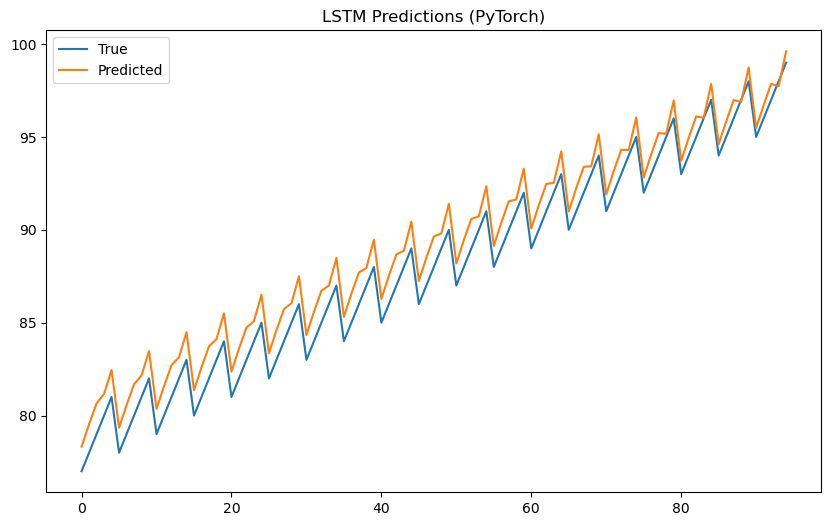

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.flatten(), label="True")
plt.plot(y_pred.flatten(), label="Predicted")
plt.title("LSTM Predictions (PyTorch)")
plt.legend()
plt.show()

In [25]:
absolute_percentage_errors = torch.abs((torch.tensor(y_test) + 1e-8 - torch.tensor(y_pred)) / (torch.tensor(y_test) + 1e-8))

# Вычисляем среднее значение абсолютных процентных ошибок
mape = torch.mean(absolute_percentage_errors) * 100

# print(absolute_percentage_errors)
print(mape.item())

1.3752623796463013
